In [ ]:
!rm -rf Project-Crowd-Counting-C-3-Framework
!git clone https://github.com/cupnootle/Project-Crowd-Counting-C-3-Framework.git
!tail Project-Crowd-Counting-C-3-Framework/.gitignore

fatal: destination path 'Project-Crowd-Counting-C-3-Framework' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path) # Uncomment to use drive

Mounted at /content/drive


In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F
import os
import imp
import time

from easydict import EasyDict as edict
from torchvision import models

In [ ]:
%ls
%cd ./Project-Crowd-Counting-C-3-Framework
%pwd

drive/  Project-Crowd-Counting-C-3-Framework/  sample_data/
/content/Project-Crowd-Counting-C-3-Framework


'/content/Project-Crowd-Counting-C-3-Framework'

In [ ]:
__C = edict()
cfg = __C
__C.SEED = 3035
__C.DATASET = 'SHHB'
if __C.DATASET == 'UCF50':
	from datasets.UCF50.setting import cfg_data
	__C.VAL_INDEX = cfg_data.VAL_INDEX 
if __C.DATASET == 'GCC':
	from datasets.GCC.setting import cfg_data
	__C.VAL_MODE = cfg_data.VAL_MODE 
__C.NET = 'CSRNet_aleatoric_dropout'
__C.PRE_GCC = False
__C.PRE_GCC_MODEL = 'path to model'
__C.RESUME = True
__C.RESUME_PATH = '/content/drive/MyDrive/C3/latest_state_MSE_lr1e-5.pth'
__C.GPU_ID = [1]
__C.LR = 1e-5
__C.LR_DECAY = 0.995
__C.LR_DECAY_START = -1
__C.NUM_EPOCH_LR_DECAY = 1
__C.MAX_EPOCH = 21
__C.LAMBDA_1 = 1e-4
__C.PRINT_FREQ = 10
now = time.strftime("%m-%d_%H-%M", time.localtime())
__C.EXP_NAME = now \
			 + '_' + __C.DATASET \
             + '_' + __C.NET \
             + '_' + str(__C.LR) + '__' + 'MSEloss_lr1e-5'
if __C.DATASET == 'UCF50':
	__C.EXP_NAME += '_' + str(__C.VAL_INDEX)	
if __C.DATASET == 'GCC':
	__C.EXP_NAME += '_' + __C.VAL_MODE	
__C.EXP_PATH = './exp'
__C.VAL_DENSE_START = 100
__C.VAL_FREQ = 10
__C.VISIBLE_NUM_IMGS = 1

In [ ]:

__C_SHHB = edict()

cfg_data = __C_SHHB

__C_SHHB.STD_SIZE = (768,1024)
__C_SHHB.TRAIN_SIZE = (576,768)
__C_SHHB.DATA_PATH = drive_path + '/MyDrive/C3/ProcessedData/shanghaitech_part_B'               

__C_SHHB.MEAN_STD = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])

__C_SHHB.LABEL_FACTOR = 1
__C_SHHB.LOG_PARA = 100.

__C_SHHB.RESUME_MODEL = ''#model path
__C_SHHB.TRAIN_BATCH_SIZE = 6 #imgs

__C_SHHB.VAL_BATCH_SIZE = 6 # 

In [ ]:
# ------------prepare enviroment------------
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

seed = cfg.SEED
if seed is not None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

gpus = cfg.GPU_ID
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device(device)
torch.backends.cudnn.benchmark = True


# ------------prepare data loader------------
data_mode = cfg.DATASET

dataset_import_path = "datasets/" + data_mode
loading_data = getattr(imp.load_source("loader", dataset_import_path + "/loading_data.py"), "loading_data")
#cfg_data = getattr(imp.load_source("settings", dataset_import_path + "/setting.py"), "cfg_data")

# ------------Prepare Trainer------------

net = cfg.NET
if net in [
    "MCNN",
    "AlexNet",
    "VGG",
    "VGG_DECODER",
    "Res50",
    "Res101",
    "CSRNet",
    "Res101_SFCN",
]:
    from trainer import Trainer
elif net in ["SANet"]:
    from trainer_for_M2TCC import Trainer  # double losses but single output
elif net in ["CMTL"]:
    from trainer_for_CMTL import Trainer  # double losses and double outputs
elif net in ["CSRNet_aleatoric", "CSRNet_aleatoric_dropout"]:
    from trainer_for_todo import Trainer # trainer with log_var


#Aleatoric loss

CSRNet model, modified so it outputs both a prediction and a log-variance (this is useful to calculate the aleatoric loss)

In [ ]:
import torch.nn as nn
import torch
from torchvision import models
import torch.nn.functional as F

class CSRNet_aleatoric(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet_aleatoric, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            self.frontend.load_state_dict(mod.features[0:23].state_dict())

        self.fc_pred = nn.Conv2d(64, 1, kernel_size=1)
        self.fc_logvar = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        pred = self.fc_pred(x)
        pred = F.softplus(pred) #softplus is a smooth approximation to ReLU
        pred = F.upsample(pred, scale_factor=8)
        logvar = F.upsample(self.fc_logvar(x), scale_factor=8)
        return pred, logvar #the model now outputs both a prediction and a logvar

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(
                in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate
            )
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [ ]:
import torch.nn as nn
import torch
from torchvision import models
import torch.nn.functional as F

class CSRNet_aleatoric_dropout(nn.Module):
    def __init__(self, load_weights=False, p=0.2):
        super(CSRNet_aleatoric_dropout, self).__init__()
        self.dropout_p = p
        self.seen = 0
        self.frontend_feat = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers_dropout(self.backend_feat, in_channels=512, dilation=True)
        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            self.frontend.load_state_dict(mod.features[0:23].state_dict())

        self.fc_pred = nn.Conv2d(64, 1, kernel_size=1)
        self.fc_logvar = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)

        pred = self.fc_pred(x)
        pred = F.softplus(pred)
        pred = F.upsample(pred, scale_factor=8)
        logvar = F.upsample(self.fc_logvar(x), scale_factor=8)
        return pred, logvar #the model now outputs both a prediction and a logvar

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(
                in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate
            )
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_layers_dropout(cfg, in_channels=3, batch_norm=False, dilation=False, dropout=0.2):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2), nn.Dropout(p=dropout)]
        else:
            conv2d = nn.Conv2d(
                in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate
            )
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True), nn.Dropout(p=dropout)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True), nn.Dropout(p=dropout)]
            in_channels = v
    return nn.Sequential(*layers)

Defining the aleatoric loss (assuming we use a Gaussian prior)

In [ ]:
import math

In [ ]:
def gaussian_log_loss(output, target, logvar, eps=1e-6):
  logvar = logvar.clone()
  with torch.no_grad():
      logvar.clamp_(min=math.log(eps))
  term1 = 0.5*torch.exp(-logvar)*(target - output)**2
  term2 = 0.5*logvar
  return (term1 + term2).mean()

In [ ]:
def laplacian_log_loss(output, target, logvar, eps=1e-6):
  logvar = logvar.clone()
  with torch.no_grad():
      logvar.clamp_(min=math.log(eps))
  term1 = 0.5*torch.exp(-logvar)*torch.abs(target - output)
  term2 = 0.5*logvar
  return (term1 + term2).mean()

Defining the CrowdCounter (I modified the loss)

In [ ]:
import pdb
import imp


class CrowdCounter_aleatoric(nn.Module):
    def __init__(self, gpus, model_name):
        super(CrowdCounter_aleatoric, self).__init__()

        self.CCN = CSRNet_aleatoric_dropout() #on colab, modify the network here
        if len(gpus) > 1:
            self.CCN = torch.nn.DataParallel(self.CCN, device_ids=gpus).cuda()
        else:
            self.CCN = self.CCN.cuda()
        self.loss_aleatoric_fn = laplacian_log_loss #on colab, modify the loss here

    @property
    def loss(self):
        return self.loss_aleatoric

    def forward(self, img, gt_map):
        density_map, logvar = self.CCN(img)
        self.loss_aleatoric = self.loss_aleatoric_fn(density_map.squeeze(), gt_map.squeeze()
        , logvar.squeeze()
        )
        return density_map, logvar

    def build_loss(self, density_map, gt_data, logvar):
        loss_aleatoric = self.loss_aleatoric(density_map.squeeze(), gt_data.squeeze(), logvar.squeeze())
        return loss_aleatoric

    def test_forward(self, img):
        density_map, logvar = self.CCN(img)
        return density_map, logvar


Modified Trainer

In [ ]:
import numpy as np
import os
import math
import time
import random
import shutil

import torch
from torch import nn


import torchvision.utils as vutils
import torchvision.transforms as standard_transforms

import pdb


def initialize_weights(models):
    for model in models:
        real_init_weights(model)


def real_init_weights(m):

    if isinstance(m, list):
        for mini_m in m:
            real_init_weights(mini_m)
    else:
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, std=0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0.0, std=0.01)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Module):
            for mini_m in m.children():
                real_init_weights(mini_m)
        else:
            print(m)


def weights_normal_init(*models):
    for model in models:
        dev = 0.01
        if isinstance(model, list):
            for m in model:
                weights_normal_init(m, dev)
        else:
            for m in model.modules():
                if isinstance(m, nn.Conv2d):
                    m.weight.data.normal_(0.0, dev)
                    if m.bias is not None:
                        m.bias.data.fill_(0.0)
                elif isinstance(m, nn.Linear):
                    m.weight.data.normal_(0.0, dev)


def logger(exp_path, exp_name, work_dir, exception, resume=False):

    from tensorboardX import SummaryWriter

    if not os.path.exists(exp_path):
        os.mkdir(exp_path)
    writer = SummaryWriter(exp_path + "/" + exp_name)
    log_file = exp_path + "/" + exp_name + "/" + exp_name + ".txt"

    cfg_file = open("./config.py", "r")
    cfg_lines = cfg_file.readlines()

    with open(log_file, "a") as f:
        f.write("".join(cfg_lines) + "\n\n\n\n")

    if not resume:
        copy_cur_env(work_dir, exp_path + "/" + exp_name + "/code", exception)

    return writer, log_file


def logger_for_CMTL(exp_path, exp_name, work_dir, exception, resume=False):

    if not os.path.exists(exp_path):
        os.mkdir(exp_path)

    if not os.path.exists(exp_path + "/" + exp_name):
        os.mkdir(exp_path + "/" + exp_name)
    log_file = exp_path + "/" + exp_name + "/" + exp_name + ".txt"

    cfg_file = open("./config.py", "r")
    cfg_lines = cfg_file.readlines()

    with open(log_file, "a") as f:
        f.write("".join(cfg_lines) + "\n\n\n\n")

    if not resume:
        copy_cur_env(work_dir, exp_path + "/" + exp_name + "/code", exception)

    return log_file


def logger_txt(log_file, epoch, scores):

    mae, mse, loss = scores

    snapshot_name = "all_ep_%d_mae_%.1f_mse_%.1f" % (epoch + 1, mae, mse)

    # pdb.set_trace()

    with open(log_file, "a") as f:
        f.write("=" * 15 + "+" * 15 + "=" * 15 + "\n\n")
        f.write(snapshot_name + "\n")
        f.write("    [mae %.2f mse %.2f], [val loss %.4f]\n" % (mae, mse, loss))
        f.write("=" * 15 + "+" * 15 + "=" * 15 + "\n\n")


def vis_results(exp_name, epoch, writer, restore, img, pred_map, gt_map):

    pil_to_tensor = standard_transforms.ToTensor()

    x = []

    for idx, tensor in enumerate(zip(img.cpu().data, pred_map, gt_map)):
        if idx > 1:  # show only one group
            break
        pil_input = restore(tensor[0])
        pil_output = torch.from_numpy(tensor[1] / (tensor[2].max() + 1e-10)).repeat(
            3, 1, 1
        )
        pil_label = torch.from_numpy(tensor[2] / (tensor[2].max() + 1e-10)).repeat(
            3, 1, 1
        )
        x.extend([pil_to_tensor(pil_input.convert("RGB")), pil_label, pil_output])
    x = torch.stack(x, 0)
    x = vutils.make_grid(x, nrow=3, padding=5)
    x = (x.numpy() * 255).astype(np.uint8)

    writer.add_image(exp_name + "_epoch_" + str(epoch + 1), x)


def print_summary(exp_name, scores, train_record):
    mae, mse, loss = scores
    print("=" * 50)
    print(exp_name)
    print("    " + "-" * 20)
    print("    [mae %.2f mse %.2f], [val loss %.4f]" % (mae, mse, loss))
    print("    " + "-" * 20)
    print(
        "[best] [model: %s] , [mae %.2f], [mse %.2f]"
        % (
            train_record["best_model_name"],
            train_record["best_mae"],
            train_record["best_mse"],
        )
    )
    print("=" * 50)


def print_WE_summary(log_txt, epoch, scores, train_record, c_maes):
    mae, mse, loss = scores
    # pdb.set_trace()
    with open(log_txt, "a") as f:
        f.write("=" * 15 + "+" * 15 + "=" * 15 + "\n")
        f.write(str(epoch) + "\n\n")
        f.write("  [mae %.4f], [val loss %.4f]\n\n" % (mae, loss))
        f.write("    list: " + str(np.transpose(c_maes.avg)) + "\n")

        f.write("=" * 15 + "+" * 15 + "=" * 15 + "\n\n")

    print("=" * 50)
    print("    " + "-" * 20)
    print("    [mae %.2f mse %.2f], [val loss %.4f]" % (mae, mse, loss))
    print("    " + "-" * 20)
    print(
        "[best] [model: %s] , [mae %.2f], [mse %.2f]"
        % (
            train_record["best_model_name"],
            train_record["best_mae"],
            train_record["best_mse"],
        )
    )
    print("=" * 50)


def print_GCC_summary(log_txt, epoch, scores, train_record, c_maes, c_mses):
    mae, mse, loss = scores
    c_mses["level"] = np.sqrt(c_mses["level"].avg)
    c_mses["time"] = np.sqrt(c_mses["time"].avg)
    c_mses["weather"] = np.sqrt(c_mses["weather"].avg)
    with open(log_txt, "a") as f:
        f.write("=" * 15 + "+" * 15 + "=" * 15 + "\n")
        f.write(str(epoch) + "\n\n")
        f.write("  [mae %.4f mse %.4f], [val loss %.4f]\n\n" % (mae, mse, loss))
        f.write(
            "  [level: mae %.4f mse %.4f]\n"
            % (np.average(c_maes["level"].avg), np.average(c_mses["level"]))
        )
        f.write("    list: " + str(np.transpose(c_maes["level"].avg)) + "\n")
        f.write("    list: " + str(np.transpose(c_mses["level"])) + "\n\n")

        f.write(
            "  [time: mae %.4f mse %.4f]\n"
            % (np.average(c_maes["time"].avg), np.average(c_mses["time"]))
        )
        f.write("    list: " + str(np.transpose(c_maes["time"].avg)) + "\n")
        f.write("    list: " + str(np.transpose(c_mses["time"])) + "\n\n")

        f.write(
            "  [weather: mae %.4f mse %.4f]\n"
            % (np.average(c_maes["weather"].avg), np.average(c_mses["weather"]))
        )
        f.write("    list: " + str(np.transpose(c_maes["weather"].avg)) + "\n")
        f.write("    list: " + str(np.transpose(c_mses["weather"])) + "\n\n")

        f.write("=" * 15 + "+" * 15 + "=" * 15 + "\n\n")

    print("=" * 50)
    print("    " + "-" * 20)
    print("    [mae %.2f mse %.2f], [val loss %.4f]" % (mae, mse, loss))
    print("    " + "-" * 20)
    print(
        "[best] [model: %s] , [mae %.2f], [mse %.2f]"
        % (
            train_record["best_model_name"],
            train_record["best_mae"],
            train_record["best_mse"],
        )
    )
    print("=" * 50)


def update_model(
    net,
    optimizer,
    scheduler,
    epoch,
    i_tb,
    exp_path,
    exp_name,
    scores,
    train_record,
    loss_tab,
    log_file=None,
):

    mae, mse, loss = scores

    snapshot_name = "all_ep_%d_mae_%.1f_mse_%.1f" % (epoch + 1, mae, mse)

    if mae < train_record["best_mae"] or mse < train_record["best_mse"]:
        train_record["best_model_name"] = snapshot_name
        if log_file is not None:
            logger_txt(log_file, epoch, scores)
        to_saved_weight = net.state_dict()
        torch.save(
            to_saved_weight, os.path.join(exp_path, exp_name, snapshot_name + ".pth")
        )

    if mae < train_record["best_mae"]:
        train_record["best_mae"] = mae
    if mse < train_record["best_mse"]:
        train_record["best_mse"] = mse

    latest_state = {
        "train_record": train_record,
        "net": net.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
        "i_tb": i_tb,
        "exp_path": exp_path,
        "exp_name": exp_name,
        "loss": loss_tab,
    }

    torch.save(latest_state, 
    '/content/drive/MyDrive/C3/latest_state_MSE_lr1e-5.pth'
    ## save latest_state on drive to avoid losing files when disconnecting from colab's environment
    )

    return train_record


def copy_cur_env(work_dir, dst_dir, exception):

    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    for filename in os.listdir(work_dir):

        file = os.path.join(work_dir, filename)
        dst_file = os.path.join(dst_dir, filename)

        if os.path.isdir(file) and exception not in filename:
            shutil.copytree(file, dst_file)
        elif os.path.isfile(file):
            shutil.copyfile(file, dst_file)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, cur_val):
        self.cur_val = cur_val
        self.sum += cur_val
        self.count += 1
        self.avg = self.sum / self.count


class AverageCategoryMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, num_class):
        self.num_class = num_class
        self.reset()

    def reset(self):
        self.cur_val = np.zeros(self.num_class)
        self.avg = np.zeros(self.num_class)
        self.sum = np.zeros(self.num_class)
        self.count = np.zeros(self.num_class)

    def update(self, cur_val, class_id):
        self.cur_val[class_id] = cur_val
        self.sum[class_id] += cur_val
        self.count[class_id] += 1
        self.avg[class_id] = self.sum[class_id] / self.count[class_id]


class Timer(object):
    """A simple timer."""

    def __init__(self):
        self.total_time = 0.0
        self.calls = 0
        self.start_time = 0.0
        self.diff = 0.0
        self.average_time = 0.0

    def tic(self):
        # using time.time instead of time.clock because time time.clock
        # does not normalize for multithreading
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.average_time = self.total_time / self.calls
        if average:
            return self.average_time
        else:
            return self.diff

In [ ]:
import numpy as np

import torch
from torch import optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from models.CC import CrowdCounter
from config import cfg as default_cfg
#from misc.utils import * #Uncomment if not on colab
import pdb

## aleatoric trainer

class Trainer:
    def __init__(self, dataloader, cfg_data, pwd, cfg=None):

        self.cfg_data = cfg_data
        if cfg is None:
            self.cfg = default_cfg
        else:
            self.cfg = cfg

        self.data_mode = self.cfg.DATASET
        self.exp_name = self.cfg.EXP_NAME
        self.exp_path = self.cfg.EXP_PATH
        self.pwd = pwd

        self.net_name = self.cfg.NET
        self.net = CrowdCounter_aleatoric(self.cfg.GPU_ID, self.net_name).cuda()
        #self.net = CrowdCounter(self.cfg.GPU_ID, self.net_name).cuda()
        self.optimizer = optim.Adam(
            self.net.CCN.parameters(), lr=self.cfg.LR, weight_decay=1e-4
        )
        self.scheduler = StepLR(
            self.optimizer,
            step_size=self.cfg.NUM_EPOCH_LR_DECAY,
            gamma=self.cfg.LR_DECAY,
        )

        self.train_record = {"best_mae": 1e20, "best_mse": 1e20, "best_model_name": ""}
        self.timer = {"iter time": Timer(), "train time": Timer(), "val time": Timer()}

        self.epoch = 0
        self.i_tb = 0

        self.loss = []

        if self.cfg.PRE_GCC:
            self.net.load_state_dict(torch.load(self.cfg.PRE_GCC_MODEL))

        self.train_loader, self.val_loader, self.restore_transform = dataloader(cfg_data=cfg_data)

        if self.cfg.RESUME:
            latest_state = torch.load(self.cfg.RESUME_PATH)
            self.net.load_state_dict(latest_state["net"])
            self.optimizer.load_state_dict(latest_state["optimizer"])
            self.scheduler.load_state_dict(latest_state["scheduler"])
            self.epoch = latest_state["epoch"] #+ 1
            self.i_tb = latest_state["i_tb"]
            self.train_record = latest_state["train_record"]
            self.exp_path = latest_state["exp_path"]
            self.exp_name = latest_state["exp_name"]
            self.loss = latest_state["loss"]

        self.writer, self.log_txt = logger(
            self.exp_path, self.exp_name, self.pwd, "exp", resume=self.cfg.RESUME
        )

    def forward(self):

        print(len(self.loss), len(self.loss)/66)

        for epoch in range(self.epoch, self.epoch + self.cfg.MAX_EPOCH):
            self.epoch = epoch
            if epoch > self.cfg.LR_DECAY_START:
                self.scheduler.step()

            # training
            self.timer["train time"].tic()
            self.train()
            self.timer["train time"].toc(average=False)

            print("train time: {:.2f}s".format(self.timer["train time"].diff))
            print("=" * 20)

            # validation
            if epoch % self.cfg.VAL_FREQ == 0 or epoch > self.cfg.VAL_DENSE_START:
                self.timer["val time"].tic()
                if self.data_mode in ["SHHA", "SHHB", "QNRF", "UCF50"]:
                    self.validate_V1()
                elif self.data_mode == "WE":
                    self.validate_V2()
                elif self.data_mode == "GCC":
                    self.validate_V3()
                self.timer["val time"].toc(average=False)
                print("val time: {:.2f}s".format(self.timer["val time"].diff))

        return (self.loss)



    def train(self):  # training for all datasets
        self.net.train()
        for i, data in enumerate(self.train_loader, 0):
            self.timer["iter time"].tic()
            img, gt_map = data
            img = Variable(img).cuda()
            gt_map = Variable(gt_map).cuda()

            self.optimizer.zero_grad()
            pred_map, logvar = self.net(img, gt_map)
            loss = self.net.loss

            loss.backward()
            self.optimizer.step()

            self.loss.append(loss.item())

            if (i + 1) % self.cfg.PRINT_FREQ == 0:

                self.i_tb += 1
                self.writer.add_scalar("train_loss", loss.item(), self.i_tb)
                self.timer["iter time"].toc(average=False)
                print(
                    "[ep %d][it %d][loss %.4f][lr %.4f][%.2fs]"
                    % (
                        self.epoch + 1,
                        i + 1,
                        loss.item(),
                        self.optimizer.param_groups[0]["lr"] * 10000,
                        self.timer["iter time"].diff,
                    )
                )
                print(
                    "        [cnt: gt: %.1f pred: %.2f]"
                    % (
                        gt_map[0].sum().data / self.cfg_data.LOG_PARA,
                        pred_map[0].sum().data / self.cfg_data.LOG_PARA,
                    )
                )
                print("logvar: " + str(logvar[0].mean().data))

    def validate_V1(self):  # validate_V1 for SHHA, SHHB, UCF-QNRF, UCF50

        self.net.eval()

        losses = AverageMeter()
        maes = AverageMeter()
        mses = AverageMeter()

        for vi, data in enumerate(self.val_loader, 0):
            img, gt_map = data

            with torch.no_grad():
                img = Variable(img).cuda()
                gt_map = Variable(gt_map).cuda()

                pred_map, logvar = self.net.forward(img, gt_map)

                pred_map = pred_map.data.cpu().numpy()
                gt_map = gt_map.data.cpu().numpy()

                for i_img in range(pred_map.shape[0]):

                    pred_cnt = np.sum(pred_map[i_img]) / self.cfg_data.LOG_PARA
                    gt_count = np.sum(gt_map[i_img]) / self.cfg_data.LOG_PARA

                    losses.update(self.net.loss.item())
                    maes.update(abs(gt_count - pred_cnt))
                    mses.update((gt_count - pred_cnt) * (gt_count - pred_cnt))
                if vi == 0:
                    vis_results(
                        self.exp_name,
                        self.epoch,
                        self.writer,
                        self.restore_transform,
                        img,
                        pred_map,
                        gt_map,
                    )

        mae = maes.avg
        mse = np.sqrt(mses.avg)
        loss = losses.avg

        self.writer.add_scalar("val_loss", loss, self.epoch + 1)
        self.writer.add_scalar("mae", mae, self.epoch + 1)
        self.writer.add_scalar("mse", mse, self.epoch + 1)

        self.train_record = update_model(
            self.net,
            self.optimizer,
            self.scheduler,
            self.epoch,
            self.i_tb,
            self.exp_path,
            self.exp_name,
            [mae, mse, loss],
            self.train_record,
            self.loss,
            self.log_txt,
        )
        print_summary(self.exp_name, [mae, mse, loss], self.train_record)

    def validate_V2(self):  # validate_V2 for WE

        self.net.eval()

        losses = AverageCategoryMeter(5)
        maes = AverageCategoryMeter(5)

        roi_mask = []
        from datasets.WE.setting import cfg_data
        from scipy import io as sio

        for val_folder in cfg_data.VAL_FOLDER:

            roi_mask.append(
                sio.loadmat(
                    os.path.join(cfg_data.DATA_PATH, "test", val_folder + "_roi.mat")
                )["BW"]
            )

        for i_sub, i_loader in enumerate(self.val_loader, 0):

            mask = roi_mask[i_sub]
            for vi, data in enumerate(i_loader, 0):
                img, gt_map = data

                with torch.no_grad():
                    img = Variable(img).cuda()
                    gt_map = Variable(gt_map).cuda()

                    pred_map, logvar = self.net.forward(img, gt_map)

                    pred_map = pred_map.data.cpu().numpy()
                    gt_map = gt_map.data.cpu().numpy()

                    for i_img in range(pred_map.shape[0]):

                        pred_cnt = np.sum(pred_map[i_img]) / self.cfg_data.LOG_PARA
                        gt_count = np.sum(gt_map[i_img]) / self.cfg_data.LOG_PARA

                        losses.update(self.net.loss.item(), i_sub)
                        maes.update(abs(gt_count - pred_cnt), i_sub)
                    if vi == 0:
                        vis_results(
                            self.exp_name,
                            self.epoch,
                            self.writer,
                            self.restore_transform,
                            img,
                            pred_map,
                            gt_map,
                        )

        mae = np.average(maes.avg)
        loss = np.average(losses.avg)

        self.writer.add_scalar("val_loss", loss, self.epoch + 1)
        self.writer.add_scalar("mae", mae, self.epoch + 1)
        self.writer.add_scalar("mae_s1", maes.avg[0], self.epoch + 1)
        self.writer.add_scalar("mae_s2", maes.avg[1], self.epoch + 1)
        self.writer.add_scalar("mae_s3", maes.avg[2], self.epoch + 1)
        self.writer.add_scalar("mae_s4", maes.avg[3], self.epoch + 1)
        self.writer.add_scalar("mae_s5", maes.avg[4], self.epoch + 1)

        self.train_record = update_model(
            self.net,
            self.optimizer,
            self.scheduler,
            self.epoch,
            self.i_tb,
            self.exp_path,
            self.exp_name,
            [mae, 0, loss],
            self.train_record,
            self.log_txt,
        )
        print_WE_summary(
            self.log_txt, self.epoch, [mae, 0, loss], self.train_record, maes
        )

    def validate_V3(self):  # validate_V3 for GCC

        self.net.eval()

        losses = AverageMeter()
        maes = AverageMeter()
        mses = AverageMeter()

        c_maes = {
            "level": AverageCategoryMeter(9),
            "time": AverageCategoryMeter(8),
            "weather": AverageCategoryMeter(7),
        }
        c_mses = {
            "level": AverageCategoryMeter(9),
            "time": AverageCategoryMeter(8),
            "weather": AverageCategoryMeter(7),
        }

        for vi, data in enumerate(self.val_loader, 0):
            img, gt_map, attributes_pt = data

            with torch.no_grad():
                img = Variable(img).cuda()
                gt_map = Variable(gt_map).cuda()

                pred_map, logvar = self.net.forward(img, gt_map)

                pred_map = pred_map.data.cpu().numpy()
                gt_map = gt_map.data.cpu().numpy()

                for i_img in range(pred_map.shape[0]):

                    pred_cnt = np.sum(pred_map[i_img]) / self.cfg_data.LOG_PARA
                    gt_count = np.sum(gt_map[i_img]) / self.cfg_data.LOG_PARA

                    s_mae = abs(gt_count - pred_cnt)
                    s_mse = (gt_count - pred_cnt) * (gt_count - pred_cnt)

                    losses.update(self.net.loss.item())
                    maes.update(s_mae)
                    mses.update(s_mse)
                    attributes_pt = attributes_pt.squeeze()
                    c_maes["level"].update(s_mae, attributes_pt[i_img][0])
                    c_mses["level"].update(s_mse, attributes_pt[i_img][0])
                    c_maes["time"].update(s_mae, attributes_pt[i_img][1] / 3)
                    c_mses["time"].update(s_mse, attributes_pt[i_img][1] / 3)
                    c_maes["weather"].update(s_mae, attributes_pt[i_img][2])
                    c_mses["weather"].update(s_mse, attributes_pt[i_img][2])

                if vi == 0:
                    vis_results(
                        self.exp_name,
                        self.epoch,
                        self.writer,
                        self.restore_transform,
                        img,
                        pred_map,
                        gt_map,
                    )

        loss = losses.avg
        mae = maes.avg
        mse = np.sqrt(mses.avg)

        self.writer.add_scalar("val_loss", loss, self.epoch + 1)
        self.writer.add_scalar("mae", mae, self.epoch + 1)
        self.writer.add_scalar("mse", mse, self.epoch + 1)

        self.train_record = update_model(
            self.net,
            self.optimizer,
            self.scheduler,
            self.epoch,
            self.i_tb,
            self.exp_path,
            self.exp_name,
            [mae, mse, loss],
            self.train_record,
            self.log_txt,
        )

        print_GCC_summary(
            self.log_txt,
            self.epoch,
            [mae, mse, loss],
            self.train_record,
            c_maes,
            c_mses,
        )


Training

In [ ]:
# ------------Start Training------------

cc_trainer = Trainer(dataloader=loading_data, cfg_data=cfg_data, cfg=cfg, pwd=drive_path + "/MyDrive/C3/")
losses = cc_trainer.forward()

2772 42.0
[ep 41][it 10][loss 0.0040][lr 0.0806][2.54s]
        [cnt: gt: 64.9 pred: 45.05]
[ep 41][it 20][loss 0.0084][lr 0.0806][2.57s]
        [cnt: gt: 106.9 pred: 99.33]
[ep 41][it 30][loss 0.0062][lr 0.0806][2.51s]
        [cnt: gt: 108.6 pred: 96.21]
[ep 41][it 40][loss 0.0057][lr 0.0806][2.53s]
        [cnt: gt: 63.0 pred: 70.17]
[ep 41][it 50][loss 0.0052][lr 0.0806][2.54s]
        [cnt: gt: 121.0 pred: 121.11]
[ep 41][it 60][loss 0.0067][lr 0.0806][2.52s]
        [cnt: gt: 98.6 pred: 44.58]
train time: 180.47s
03-12_18-18_SHHB_CSRNet_1e-05__MSEloss_lr1e-5
    --------------------
    [mae 46.91 mse 52.56], [val loss 0.0067]
    --------------------
[best] [model: all_ep_11_mae_13.9_mse_21.9] , [mae 13.94], [mse 21.92]
val time: 67.57s
[ep 42][it 10][loss 0.0069][lr 0.0802][2.57s]
        [cnt: gt: 124.6 pred: 172.80]
[ep 42][it 20][loss 0.0048][lr 0.0802][2.55s]
        [cnt: gt: 58.0 pred: 85.98]
[ep 42][it 30][loss 0.0078][lr 0.0802][2.51s]
        [cnt: gt: 95.0 pred: 129.

In [ ]:
## Averaging the loss over iterations

latest_state = torch.load('/content/drive/MyDrive/C3/GOOD_GAUSS_EP_70.pth'
                          )
loss = latest_state["loss"]
loss_means = []
for x in range(0, len(loss), 66):
    every_chunk = loss[x: 66+x]
    mean = np.mean(every_chunk)
    loss_means.append(mean)
print(len(loss_means))

72


72


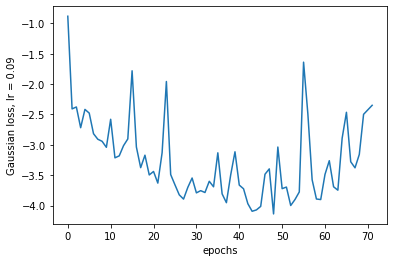

In [ ]:
##Plotting the loss

import matplotlib.pyplot as plt

plt.plot(loss_means)
plt.xlabel("epochs")
print(len(loss_means))

Test

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import os
import random
import torch
from torch.autograd import Variable
import torchvision.transforms as standard_transforms
import misc.transforms as own_transforms
import pandas as pd

from models.CC import CrowdCounter
from config import cfg as default_cfg
from misc.utils import *
import scipy.io as sio
from PIL import Image, ImageOps

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

exp_name = "../SHHB_results"
if not os.path.exists(exp_name):
    os.mkdir(exp_name)

if not os.path.exists(exp_name + "/pred"):
    os.mkdir(exp_name + "/pred")

if not os.path.exists(exp_name + "/gt"):
    os.mkdir(exp_name + "/gt")

mean_std = (
    [0.452016860247, 0.447249650955, 0.431981861591],
    [0.23242045939, 0.224925786257, 0.221840232611],
)
img_transform = standard_transforms.Compose(
    [standard_transforms.ToTensor(), standard_transforms.Normalize(*mean_std)]
)
restore = standard_transforms.Compose(
    [own_transforms.DeNormalize(*mean_std), standard_transforms.ToPILImage()]
)
pil_to_tensor = standard_transforms.ToTensor()

dataRoot = drive_path + "/MyDrive/C3/ProcessedData/shanghaitech_part_B/test"
## Modify the model path everytime
model_path = drive_path + "/MyDrive/C3/" + "latest_state_lap_lr5e-6.pth"


def main(num_samples=100):
    file_list = [filename for root, dirs, filename in os.walk(dataRoot + "/img/")]
    gts_list = []
    preds_list = []
    logvars_list = []
    for i in range(0, num_samples):
      gts, preds, logvars = test(file_list[0], model_path)
      gts_list.append(gts)
      preds_list.append(preds)
      logvars_list.append(logvars)
    return (gts_list, preds_list, logvars_list)

def test(file_list, model_path):
    net = CrowdCounter_aleatoric(cfg.GPU_ID, 'CSRNet_aleatoric_dropout')
    latest_state = torch.load(model_path)
    net.load_state_dict(latest_state["net"])
    net.cuda()
    #net.eval() #Uncomment if not using Dropout for MC Dropout
    net.train() #Comment if not using Dropout for MC Dropout

    f1 = plt.figure(1)

    gts = []
    preds = []
    logvars = []

    for filename in file_list:
        print(filename)
        imgname = dataRoot + "/img/" + filename
        filename_no_ext = filename.split(".")[0]

        denname = dataRoot + "/den/" + filename_no_ext + ".csv"

        den = pd.read_csv(denname, sep=",", header=None).values
        den = den.astype(np.float32, copy=False)

        img = Image.open(imgname)

        if img.mode == "L":
            img = img.convert("RGB")

        img = img_transform(img)

        gt = np.sum(den)
        with torch.no_grad():
            img = Variable(img[None, :, :, :]).cuda()
            pred_map, logvar = net.test_forward(img)
            gts.append(gt)
            preds.append(pred_map[0].sum().data /100.)
            logvars.append(logvar[0].mean().data)

        sio.savemat(
            exp_name + "/pred/" + filename_no_ext + ".mat",
            {"data": pred_map.squeeze().cpu().numpy() / 100.0},
        )
        sio.savemat(exp_name + "/gt/" + filename_no_ext + ".mat", {"data": den})

        pred_map = pred_map.cpu().data.numpy()[0, 0, :, :]

        pred = np.sum(pred_map) / 100.0
        pred_map = pred_map / np.max(pred_map + 1e-20)

        den = den / np.max(den + 1e-20)

        den_frame = plt.gca()
        plt.imshow(den, "jet")
        den_frame.axes.get_yaxis().set_visible(False)
        den_frame.axes.get_xaxis().set_visible(False)
        den_frame.spines["top"].set_visible(False)
        den_frame.spines["bottom"].set_visible(False)
        den_frame.spines["left"].set_visible(False)
        den_frame.spines["right"].set_visible(False)
        plt.savefig(
            '/content/drive/MyDrive/C3/results_LAPLACE_lr5e-6/' + filename_no_ext + "_gt_" + str(int(gt)) + ".png",
            #Saving results to local drive to avoid losing files when disconnecting from colab environment
            bbox_inches="tight",
            pad_inches=0,
            dpi=150,
        )

        plt.close()

        pred_frame = plt.gca()
        plt.imshow(pred_map, "jet")
        pred_frame.axes.get_yaxis().set_visible(False)
        pred_frame.axes.get_xaxis().set_visible(False)
        pred_frame.spines["top"].set_visible(False)
        pred_frame.spines["bottom"].set_visible(False)
        pred_frame.spines["left"].set_visible(False)
        pred_frame.spines["right"].set_visible(False)
        plt.savefig(
            '/content/drive/MyDrive/C3/results_LAPLACE_lr5e-6/' + filename_no_ext + "_pred_" + str(float(pred)) + ".png",
            bbox_inches="tight",
            pad_inches=0,
            dpi=150,
        )

        plt.close()

        diff = den - pred_map

        diff_frame = plt.gca()
        plt.imshow(diff, "jet")
        plt.colorbar()
        diff_frame.axes.get_yaxis().set_visible(False)
        diff_frame.axes.get_xaxis().set_visible(False)
        diff_frame.spines["top"].set_visible(False)
        diff_frame.spines["bottom"].set_visible(False)
        diff_frame.spines["left"].set_visible(False)
        diff_frame.spines["right"].set_visible(False)
        plt.savefig(
            '/content/drive/MyDrive/C3/results_LAPLACE_lr5e-6/' + filename_no_ext + "_diff.png",
            bbox_inches="tight",
            pad_inches=0,
            dpi=150,
        )

        plt.close()

    return (gts, preds, logvars)

gts_list_LAPLACE, preds_list_LAPLACE, logvars_list_LAPLACE = main()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


105.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


112.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


108.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


110.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


10.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


111.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


116.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


103.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


107.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


114.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


109.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


101.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


102.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


118.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


117.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


106.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


113.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


115.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


104.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


11.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


1.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


100.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


141.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


130.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


131.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


133.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


142.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


137.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


134.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


135.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


120.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


13.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


125.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


12.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


129.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


146.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


122.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


14.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


136.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


119.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


143.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


139.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


144.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


123.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


127.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


128.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


124.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


121.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


145.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


132.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


126.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


140.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


138.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


148.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


152.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


153.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


168.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


175.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


156.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


151.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


158.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


169.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


164.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


167.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


163.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


160.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


174.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


161.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


147.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


170.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


155.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


149.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


166.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


173.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


17.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


172.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


157.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


165.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


15.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


154.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


171.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


159.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


16.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


150.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


162.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


2.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


186.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


178.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


183.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


18.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


187.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


181.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


190.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


198.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


180.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


192.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


195.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


200.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


191.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


189.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


185.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


194.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


20.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


193.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


188.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


176.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


19.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


201.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


197.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


182.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


184.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


179.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


177.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


196.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


199.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


224.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


22.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


223.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


204.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


203.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


205.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


208.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


209.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


220.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


207.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


216.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


225.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


218.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


219.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


221.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


206.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


222.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


217.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


21.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


202.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


211.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


213.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


214.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


212.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


215.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


210.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


229.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


248.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


231.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


234.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


244.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


245.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


251.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


250.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


241.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


239.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


230.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


246.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


235.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


228.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


227.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


24.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


233.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


243.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


226.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


240.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


249.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


236.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


247.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


252.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


23.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


238.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


232.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


25.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


242.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


237.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


265.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


253.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


254.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


263.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


267.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


269.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


261.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


270.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


272.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


274.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


266.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


256.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


260.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


259.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


258.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


276.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


257.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


275.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


277.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


262.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


255.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


271.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


26.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


268.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


273.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


27.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


264.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


287.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


298.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


294.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


282.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


299.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


29.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


288.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


285.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


284.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


281.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


295.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


28.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


286.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


296.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


297.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


3.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


289.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


290.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


279.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


300.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


30.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


292.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


301.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


280.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


278.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


283.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


291.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


293.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


316.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


312.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


307.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


313.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


309.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


4.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


314.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


42.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


308.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


303.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


39.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


306.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


304.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


35.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


34.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


305.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


38.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


36.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


315.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


310.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


32.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


302.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


311.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


33.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


41.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


31.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


40.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


37.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


62.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


45.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


50.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


69.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


48.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


59.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


61.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


44.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


7.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


53.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


67.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


6.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


58.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


5.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


43.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


55.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


56.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


63.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


57.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


52.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


51.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


54.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


46.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


66.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


68.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


64.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


60.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


65.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


49.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


47.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


70.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


76.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


92.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


90.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


73.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


8.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


75.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


78.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


77.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


72.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


89.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


91.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


84.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


87.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


85.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


86.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


81.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


9.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


74.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


83.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


79.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


94.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


88.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


80.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


93.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


71.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


82.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


97.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


98.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


96.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


95.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


99.jpg


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


# Bayesian Loss

In [ ]:
model = torch.load(drive_path + '/MyDrive/C3/best_model_shb.pth')

In [ ]:
model.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.16.weight', 'features.16.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.23.weight', 'features.23.bias', 'features.25.weight', 'features.25.bias', 'features.28.weight', 'features.28.bias', 'features.30.weight', 'features.30.bias', 'features.32.weight', 'features.32.bias', 'features.34.weight', 'features.34.bias', 'reg_layer.0.weight', 'reg_layer.0.bias', 'reg_layer.2.weight', 'reg_layer.2.bias', 'reg_layer.4.weight', 'reg_layer.4.bias'])

In [ ]:
drive_path + '/MyDrive/C3/ProcessedData/shanghaitech_part_B'

'/content/drive/MyDrive/C3/ProcessedData/shanghaitech_part_B'

In [ ]:
!python3 preprocess_dataset.py --origin-dir /content/drive/MyDrive/C3/UCF-QNRF_ECCV18/UCF-QNRF_ECCV18 --data-dir /content/drive/MyDrive/C3

img_0932.jpg
img_0933.jpg
img_0935.jpg
img_0936.jpg
img_0937.jpg
img_0941.jpg
img_0942.jpg
img_0945.jpg
img_0947.jpg
img_0948.jpg
img_0950.jpg
img_0007.jpg
img_0012.jpg
img_0027.jpg
img_0033.jpg
img_0038.jpg
img_0042.jpg
img_0054.jpg
img_0062.jpg
img_0065.jpg
img_0067.jpg
img_0068.jpg
img_0086.jpg
img_0091.jpg
img_0097.jpg
img_0103.jpg
img_0114.jpg
img_0116.jpg
img_0119.jpg
img_0125.jpg
img_0128.jpg
img_0152.jpg
img_0157.jpg
img_0190.jpg
img_0191.jpg
img_0221.jpg
img_0250.jpg
img_0251.jpg
img_0257.jpg
img_0268.jpg
img_0280.jpg
img_0289.jpg
img_0291.jpg
img_0302.jpg
img_0303.jpg
img_0338.jpg
img_0339.jpg
img_0344.jpg
img_0347.jpg
img_0357.jpg
img_0379.jpg
img_0382.jpg
img_0385.jpg
img_0416.jpg
img_0441.jpg
img_0470.jpg
img_0472.jpg
img_0477.jpg
img_0485.jpg
img_0489.jpg
img_0505.jpg
img_0510.jpg
img_0514.jpg
img_0521.jpg
Traceback (most recent call last):
  File "preprocess_dataset.py", line 90, in <module>
    im.save(im_save_path)
  File "/usr/local/lib/python3.8/dist-packages/PIL/Ima

In [ ]:
!python train_bay.py --data-dir /content/drive/MyDrive/C3 --save-dir /content/drive/MyDrive/C3

1
03-13 22:42:12 data_dir: /content/drive/MyDrive/C3
03-13 22:42:12 save_dir: /content/drive/MyDrive/C3
03-13 22:42:12 lr: 1e-05
03-13 22:42:12 weight_decay: 0.0001
03-13 22:42:12 resume: 
03-13 22:42:12 max_model_num: 1
03-13 22:42:12 max_epoch: 1000
03-13 22:42:12 val_epoch: 5
03-13 22:42:12 val_start: 600
03-13 22:42:12 batch_size: 1
03-13 22:42:12 device: 0
03-13 22:42:12 num_workers: 8
03-13 22:42:12 is_gray: False
03-13 22:42:12 crop_size: 512
03-13 22:42:12 downsample_ratio: 8
03-13 22:42:12 use_background: True
03-13 22:42:12 sigma: 8.0
03-13 22:42:12 background_ratio: 1.0
03-13 22:42:13 using 1 gpus
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker num

In [ ]:
!python test_bay.py --data-dir /content/drive/MyDrive/C3 --save-dir /content/drive/MyDrive/C3

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
('img_0001',) -317.4150390625 975 1292.4150390625
('img_0002',) 234.6561279296875 923 688.3438720703125
('img_0003',) -17.498046875 350 367.498046875
('img_0004',) -4.5587158203125 183 187.5587158203125
('img_0005',) -12.600021362304688 103 115.600021362